In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
import fuzzymatcher


In [32]:

# Data loading
def get_data():
    data1 = pd.read_csv('raw_data/parte1.csv', sep=';', encoding = 'iso-8859-1')
    data2 = pd.read_csv('raw_data/parte2.csv', sep=';', encoding = 'iso-8859-1')
    data3 = pd.read_csv('raw_data/parte3.csv', sep=';', encoding = 'iso-8859-1')
    data4 = pd.read_csv('raw_data/parte4.csv', sep=';', encoding = 'iso-8859-1')
    kept_columns = ['controle', 'titulo_do', 'total_rbft', 'cisp', 'data_fato', 'hora_fato', 'local', 'bairro_fato']
    eng_columns = ['Crime_ID', 'Crime_sub_type', 'Crime_type', 'Police_station', 'Date', 'Time', 'Place_type', 'Neighborhood']
    return data1, data2, data3, data4, kept_columns, eng_columns

# Import data with correct bairros and AR names
def get_bairros_data():
    bairros_all = pd.read_csv("raw_data/bairros_lista.csv", encoding='iso-8859-1')
    return bairros_all


# Cleaning function
def merge_clean(data1, data2, data3, data4):

    # Merging
    data = pd.concat([data1, data2, data3, data4]) # Merging all datasets

    # Focusing on Rio de Janeiro only
    data = data[data['municipio_fato'] == 'Rio de Janeiro (Capital)'] # Filtering on Rio de Janeiro only

    # Columns transforming
    data = data[kept_columns] # Removing useless columns
    data.columns = eng_columns  # Renaming columns in English

    # Date and Time preprocessing
    data = data[data['Time'] != '99'] # Removing invalid time format
    data['Date_Time'] = pd.to_datetime(data['Date'] + ' '
                                      + data['Time'], format='%Y-%m-%d %H:%M') # Passing to datetime format
    data.drop(columns=['Date', 'Time'], inplace=True) # Removing time and date columns once the Date_Time is created
    data = data[data['Date_Time'] > '2008-01-31'] # Removing irrelevant date samples

    # Missing values, duplicates & text standardizing
    data = data.drop_duplicates(subset="Crime_ID") # Removing duplicates
    data['Neighborhood'] = data['Neighborhood'].map(lambda x: unidecode.unidecode(x)) # Removing accents
    data = data[data['Neighborhood'] != 'sem informacao'] # Removing missing values for neighborhood

    return data

# Bairra detail
def barra_replace(row):
    if row == "Barra":
        row= "Barra da Tijuca"
    return row

# Bairros/AR matching
def get_AR(data, ar_data): #data_AR should be the full table with bairros and AR

    data['Neighborhood'] = data['Neighborhood'].map(barra_replace) # Setting the good "Barra da Tijuca" name

    # Bairros matching
    bairros = pd.DataFrame(ar_data, columns=["Bairro"]) # Creating a table with only the bairros
    bairros.set_index("Bairro")
    data = fuzzymatcher.fuzzy_left_join(data, bairros, left_on="Neighborhood", right_on="Bairro") # Replacing non-standardized bairros names with standardized ones
    data = data.drop(columns=['best_match_score', '__id_left', '__id_right', 'Neighborhood']) # Removing useless columns
    data.rename(columns={'Bairro': 'Neighborhood'}, inplace=True)
    data = pd.merge(data,ar_data,left_on='Neighborhood', right_on='Bairro',how='left').drop(columns=["Regiao","IDS","Bairro",'N¼']) # Aggreagting the right AR names to our new bairros
    data.rename(columns={'R.A': 'RA'}, inplace=True)
    data = data.dropna(subset='RA') # Removing lines with no bairros/AR information

    return data

# Cleaning - all
def clean_all(data1, data2, data3, data4, ar_data):
    data = merge_clean(data1, data2, data3, data4)
    data = get_AR(data, ar_data)

    return data

In [33]:
data1, data2, data3, data4, kept_columns, eng_columns = get_data()

In [34]:
data = merge_clean(data1, data2, data3, data4)

In [37]:
data.dtypes

Crime_ID                  object
Crime_sub_type            object
Crime_type                object
Police_station            object
Place_type                object
Neighborhood              object
Date_Time         datetime64[ns]
dtype: object

In [38]:
data['Neighborhood'] = data['Neighborhood'].map(barra_replace)

In [39]:
get_bairros_data()

,N¼,Bairro,R.A,Regiao,IDS
0,1,Lagoa,Lagoa,Zona Sul,0.854
1,2,Leblon,Lagoa,Zona Sul,"0,809"
2,3,Ipanema,Lagoa,Zona Sul,"0,801"
3,4,Humaita,Botafogo,Zona Sul,"0,798"
4,5,Urca,Botafogo,Zona Sul,"0,795"
...,...,...,...,...,...
153,154,Guaratiba,Guaratiba,Zona Oeste,"0,433"
154,155,Vargem Pequena,Barra da Tijuca,Zona Oeste,"0,425"
155,156,Vargem Grande,Barra da Tijuca,Zona Oeste,"0,408"
156,157,Camorim,Jacarepagua,Zona Oeste,"0,369"


In [40]:
bairros = pd.DataFrame(get_bairros_data(), columns=["Bairro"]) # Creating a table with only the bairros


In [41]:
bairros

,Bairro
0,Lagoa
1,Leblon
2,Ipanema
3,Humaita
4,Urca
...,...
153,Guaratiba
154,Vargem Pequena
155,Vargem Grande
156,Camorim


In [43]:
bairros.set_index("Bairro")


""
Bairro
Lagoa
Leblon
Ipanema
Humaita
Urca
...
Guaratiba
Vargem Pequena
Vargem Grande


In [44]:
data = fuzzymatcher.fuzzy_left_join(data, bairros, left_on="Neighborhood", right_on="Bairro") # Replacing non-standardized bairros names with standardized ones

In [45]:
data = data.drop(columns=['best_match_score', '__id_left', '__id_right', 'Neighborhood']) # Removing useless columns


In [46]:
data.rename(columns={'Bairro': 'Neighborhood'}, inplace=True)

In [48]:
data = pd.merge(data,get_bairros_data(),left_on='Neighborhood', right_on='Bairro',how='left').drop(columns=["Regiao","IDS","Bairro",'N¼']) # Aggreagting the right AR names to our new bairros


In [49]:
data.rename(columns={'R.A': 'RA'}, inplace=True)

In [51]:
data = data.dropna(subset=['RA']) # Removing lines with no bairros/AR information

In [52]:
data

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,RA
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba
1,01137431-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,2009-01-01 19:00:00,Santissimo,Campo Grande
2,02023941-2009,Lesão corporal dolosa,Não se aplica,040a. Honório Gurgel,Residência,2008-12-31 20:30:00,Honorio Gurgel,Madureira
4,04751871-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Via pública,2009-01-01 01:30:00,Campo Grande,Campo Grande
5,04909311-2009,Ameaça,Não se aplica,039a. Pavuna,Residência,2009-01-01 03:03:00,Ricardo de Albuquerque,Anchieta
...,...,...,...,...,...,...,...,...
1220307,96730181-2019,Roubo em coletivo,Roubo,027a. Vicente de Carvalho,Interior de coletivo,2019-12-19 20:55:00,Iraja,Iraja
1220308,97578571-2019,Furto a transeunte,Furto,012a. Copacabana,Praia,2019-12-31 17:00:00,Copacabana,Copacabana
1220309,98313421-2019,Furto a transeunte,Furto,012a. Copacabana,Via pública,2019-12-29 19:00:00,Copacabana,Copacabana
1220310,98452031-2019,Furto a transeunte,Furto,014a. Leblon,Interior de coletivo,2019-12-30 11:45:00,Centro,Centro


In [56]:
data.Date_Time.isnull().sum()

0

In [68]:
data

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,RA
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba
1,01137431-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,2009-01-01 19:00:00,Santissimo,Campo Grande
2,02023941-2009,Lesão corporal dolosa,Não se aplica,040a. Honório Gurgel,Residência,2008-12-31 20:30:00,Honorio Gurgel,Madureira
4,04751871-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Via pública,2009-01-01 01:30:00,Campo Grande,Campo Grande
5,04909311-2009,Ameaça,Não se aplica,039a. Pavuna,Residência,2009-01-01 03:03:00,Ricardo de Albuquerque,Anchieta
...,...,...,...,...,...,...,...,...
1220307,96730181-2019,Roubo em coletivo,Roubo,027a. Vicente de Carvalho,Interior de coletivo,2019-12-19 20:55:00,Iraja,Iraja
1220308,97578571-2019,Furto a transeunte,Furto,012a. Copacabana,Praia,2019-12-31 17:00:00,Copacabana,Copacabana
1220309,98313421-2019,Furto a transeunte,Furto,012a. Copacabana,Via pública,2019-12-29 19:00:00,Copacabana,Copacabana
1220310,98452031-2019,Furto a transeunte,Furto,014a. Leblon,Interior de coletivo,2019-12-30 11:45:00,Centro,Centro


In [64]:
from pop_data import clean_pop_data

In [65]:
pop_data = clean_pop_data()

In [66]:
pop_data

,Ano,Populacao,administrative_regions
0,2000,39973.0,Portuaria
1,2001,39246.0,Portuaria
2,2002,38519.0,Portuaria
3,2003,37792.0,Portuaria
4,2004,37065.0,Portuaria
...,...,...,...
667,2016,32933.8,Cidade de Deus
668,2017,32610.6,Cidade de Deus
669,2018,32287.4,Cidade de Deus
670,2019,31964.2,Cidade de Deus


In [71]:
data['Year'] = pd.DatetimeIndex(data.Date_Time).year

/var/folders/7b/hgztdlzd4k76rwydg33k1vhm0000gn/T/ipykernel_54361/4142032728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'] = pd.DatetimeIndex(data.Date_Time).year


In [72]:
data

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,RA,Year
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba,2009
1,01137431-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,2009-01-01 19:00:00,Santissimo,Campo Grande,2009
2,02023941-2009,Lesão corporal dolosa,Não se aplica,040a. Honório Gurgel,Residência,2008-12-31 20:30:00,Honorio Gurgel,Madureira,2008
4,04751871-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Via pública,2009-01-01 01:30:00,Campo Grande,Campo Grande,2009
5,04909311-2009,Ameaça,Não se aplica,039a. Pavuna,Residência,2009-01-01 03:03:00,Ricardo de Albuquerque,Anchieta,2009
...,...,...,...,...,...,...,...,...,...
1220307,96730181-2019,Roubo em coletivo,Roubo,027a. Vicente de Carvalho,Interior de coletivo,2019-12-19 20:55:00,Iraja,Iraja,2019
1220308,97578571-2019,Furto a transeunte,Furto,012a. Copacabana,Praia,2019-12-31 17:00:00,Copacabana,Copacabana,2019
1220309,98313421-2019,Furto a transeunte,Furto,012a. Copacabana,Via pública,2019-12-29 19:00:00,Copacabana,Copacabana,2019
1220310,98452031-2019,Furto a transeunte,Furto,014a. Leblon,Interior de coletivo,2019-12-30 11:45:00,Centro,Centro,2019


In [75]:
data_merge = pd.merge(left=data, right=pop_data, left_on=["RA","Year"],right_on=["administrative_regions", "Ano"])

In [76]:
data_merge

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,RA,Year,Ano,Populacao,administrative_regions
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba,2009,2009,131901.6,Guaratiba
1,07177211-2009,Lesão corporal culposa de trânsito,Não se aplica,016a. Barra da Tijuca,Via pública,2009-01-01 19:10:00,Barra de Guaratiba,Guaratiba,2009,2009,131901.6,Guaratiba
2,21813091-2009,Ameaça,Não se aplica,043a. Pedra de Guaratiba,Residência,2009-01-01 05:30:00,Guaratiba,Guaratiba,2009,2009,131901.6,Guaratiba
3,37974231-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Via pública,2009-01-01 19:30:00,Guaratiba,Guaratiba,2009,2009,131901.6,Guaratiba
4,73801671-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Residência,2009-01-01 03:40:00,Barra de Guaratiba,Guaratiba,2009,2009,131901.6,Guaratiba
...,...,...,...,...,...,...,...,...,...,...,...,...
1135254,70645371-2019,Furto de veículos,Furto,021a. Bonsucesso,Via pública,2019-07-08 05:00:00,Jacarezinho,Jacarezinho,2019,2019,24065.0,Jacarezinho
1135255,42741691-2019,Homicídio doloso,Não se aplica,025a. Engenho Novo,"Hospital, clínica e similares",2019-09-01 02:49:00,Jacarezinho,Jacarezinho,2019,2019,24065.0,Jacarezinho
1135256,18847651-2019,Furto a transeunte,Furto,025a. Engenho Novo,Favela,2019-11-25 01:25:00,Jacarezinho,Jacarezinho,2019,2019,24065.0,Jacarezinho
1135257,68517021-2019,Furto de telefone celular,Furto,021a. Bonsucesso,Interior de coletivo,2019-12-18 14:20:00,Jacarezinho,Jacarezinho,2019,2019,24065.0,Jacarezinho


In [79]:
data_merge.drop(columns=["administrative_regions","Ano","Year"], inplace = True)

In [80]:
data_merge

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,RA,Populacao
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba,131901.6
1,07177211-2009,Lesão corporal culposa de trânsito,Não se aplica,016a. Barra da Tijuca,Via pública,2009-01-01 19:10:00,Barra de Guaratiba,Guaratiba,131901.6
2,21813091-2009,Ameaça,Não se aplica,043a. Pedra de Guaratiba,Residência,2009-01-01 05:30:00,Guaratiba,Guaratiba,131901.6
3,37974231-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Via pública,2009-01-01 19:30:00,Guaratiba,Guaratiba,131901.6
4,73801671-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Residência,2009-01-01 03:40:00,Barra de Guaratiba,Guaratiba,131901.6
...,...,...,...,...,...,...,...,...,...
1135254,70645371-2019,Furto de veículos,Furto,021a. Bonsucesso,Via pública,2019-07-08 05:00:00,Jacarezinho,Jacarezinho,24065.0
1135255,42741691-2019,Homicídio doloso,Não se aplica,025a. Engenho Novo,"Hospital, clínica e similares",2019-09-01 02:49:00,Jacarezinho,Jacarezinho,24065.0
1135256,18847651-2019,Furto a transeunte,Furto,025a. Engenho Novo,Favela,2019-11-25 01:25:00,Jacarezinho,Jacarezinho,24065.0
1135257,68517021-2019,Furto de telefone celular,Furto,021a. Bonsucesso,Interior de coletivo,2019-12-18 14:20:00,Jacarezinho,Jacarezinho,24065.0


In [83]:
data_merge_centro = data_merge[data_merge.RA == "Centro"]

In [84]:
data_merge_centro

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,RA,Populacao
38689,35291951-2009,Ameaça,Não se aplica,005a. Mem de Sá,Estabelecimento comercial,2008-12-31 15:00:00,Centro,Centro,30022.4
38690,79232411-2009,Ameaça,Não se aplica,004a. Praça da República,Estabelecimento comercial,2008-11-07 16:00:00,Centro,Centro,30022.4
38691,33711511-2009,Lesão corporal dolosa,Não se aplica,004a. Praça da República,Via pública,2008-12-29 10:05:00,Centro,Centro,30022.4
38692,08528251-2009,Ameaça,Não se aplica,005a. Mem de Sá,Escritório,2008-12-23 09:00:00,Centro,Centro,30022.4
38693,86839681-2009,Ameaça,Não se aplica,004a. Praça da República,Outros,2008-12-30 00:00:00,Centro,Centro,30022.4
...,...,...,...,...,...,...,...,...,...
1098073,67853881-2019,Furto a transeunte,Furto,005a. Mem de Sá,Via pública,2019-12-30 21:00:00,Centro,Centro,20590.8
1098074,76335831-2019,Furto a transeunte,Furto,005a. Mem de Sá,Via pública,2019-12-29 03:30:00,Centro,Centro,20590.8
1098075,82480471-2019,Furto a transeunte,Furto,005a. Mem de Sá,Via pública,2019-12-31 09:00:00,Centro,Centro,20590.8
1098076,98452031-2019,Furto a transeunte,Furto,014a. Leblon,Interior de coletivo,2019-12-30 11:45:00,Centro,Centro,20590.8


In [85]:
data_merge_centro["year"] = pd.DatetimeIndex(data_merge_centro.Date_Time).year

/var/folders/7b/hgztdlzd4k76rwydg33k1vhm0000gn/T/ipykernel_54361/269281284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merge_centro["year"] = pd.DatetimeIndex(data_merge_centro.Date_Time).year


In [88]:
data_merge_centro2 = data_merge_centro.groupby("year").mean()

In [90]:
data_merge_centro2.reset_index(inplace=True)

In [91]:
data_merge_centro2

,year,Populacao
0,2008,30022.4
1,2009,28997.2
2,2010,27972.0
3,2011,27097.2
4,2012,26222.4
5,2013,25347.6
6,2014,24472.8
7,2015,23598.0
8,2016,22846.2
9,2017,22094.4


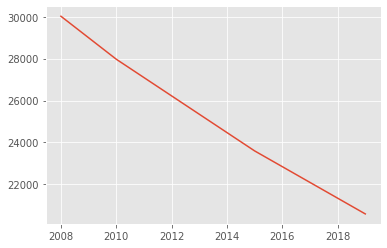

In [93]:
plt.plot(data_merge_centro2.year, data_merge_centro2.Populacao)

In [97]:
pop_data_centro = pop_data[pop_data.administrative_regions == "Centro"]

In [99]:
pop_data_centro

,Ano,Populacao,administrative_regions
21,2000,39135.0,Centro
22,2001,37927.6,Centro
23,2002,36720.2,Centro
24,2003,35512.8,Centro
25,2004,34305.4,Centro
26,2005,33098.0,Centro
27,2006,32072.8,Centro
28,2007,31047.6,Centro
29,2008,30022.4,Centro
30,2009,28997.2,Centro


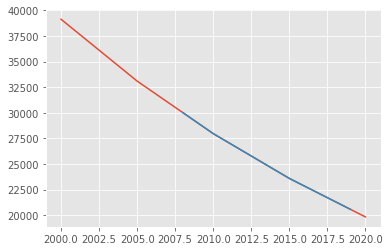

In [101]:
plt.plot(pop_data_centro.Ano, pop_data_centro.Populacao)
plt.plot(data_merge_centro2.year, data_merge_centro2.Populacao)

In [104]:
import clean2
from datetime import datetime


In [109]:
print("start time  =", datetime.now())
print("************* QC get_data() *************************")
data1, data2, data3, data4 = clean2.get_data()
print(data1.head())
print("************* QC get_bairros_data() *****************")
bairros_all = clean2.get_bairros_data()
print(bairros_all.head())
print("************* QC merge_clean() **********************")
data = clean2.merge_clean(data1, data2, data3, data4)
print(data.head())
print("************* QC get_AR() ***************************")
rio_df = clean2.get_AR(data, bairros_all)
print(rio_df.head())
#data = clean_all(data1, data2, data3, data4, get_bairros_data())
#print(data.head(5))
print("end time  =", datetime.now())

start time  = 2022-03-01 21:13:27.793941
************* QC get_data() *************************
        controle   ano      mes              titulo_do     total_rbft  \
0  00787401-2009  2009  Janeiro  Lesão corporal dolosa  Não se aplica   
1  00908861-2009  2009  Janeiro  Lesão corporal dolosa  Não se aplica   
2  00954561-2009  2009  Janeiro  Lesão corporal dolosa  Não se aplica   
3  00987771-2009  2009  Janeiro  Lesão corporal dolosa  Não se aplica   
4  00987771-2009  2009  Janeiro  Lesão corporal dolosa  Não se aplica   

  conteudo                                                 dp  \
0  vítimas                           043a. Pedra de Guaratiba   
1  vítimas                                   119a. Rio Bonito   
2  vítimas  Delegacia de Atendimento à Mulher - Volta Redonda   
3  vítimas                            145a. São João da Barra   
4  vítimas                            145a. São João da Barra   

                       cisp    data_com   data_fato  ...     risp  \
0  043

In [110]:
rio_df

,best_match_score,__id_left,__id_right,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Neighborhood,Date_Time,Bairro
0,-0.214711,0_left,114_right,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,PRAIA DA BRISA/PEDRA DE GUARAT,2009-01-01 04:30:00,Pedra de Guaratiba
16,0.162033,1_left,139_right,01137431-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,SANTISSIMO,2009-01-01 19:00:00,Santissimo
17,0.405996,2_left,107_right,02023941-2009,Lesão corporal dolosa,Não se aplica,040a. Honório Gurgel,Residência,HONORIO GURGEL,2008-12-31 20:30:00,Honorio Gurgel
18,NaN,3_left,None,02646521-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,VASCONCELOS,2009-01-01 19:00:00,NaN
19,0.278060,4_left,128_right,04751871-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Via pública,CAMPO GRANDE,2009-01-01 01:30:00,Campo Grande
...,...,...,...,...,...,...,...,...,...,...,...
1405233,0.243963,1220307_left,61_right,96730181-2019,Roubo em coletivo,Roubo,027a. Vicente de Carvalho,Interior de coletivo,Iraja,2019-12-19 20:55:00,Iraja
1405234,0.162033,1220308_left,13_right,97578571-2019,Furto a transeunte,Furto,012a. Copacabana,Praia,Copacabana,2019-12-31 17:00:00,Copacabana
1405235,0.162033,1220309_left,13_right,98313421-2019,Furto a transeunte,Furto,012a. Copacabana,Via pública,Copacabana,2019-12-29 19:00:00,Copacabana
1405236,0.146129,1220310_left,46_right,98452031-2019,Furto a transeunte,Furto,014a. Leblon,Interior de coletivo,Centro,2019-12-30 11:45:00,Centro


In [111]:
rio_df = rio_df.drop(columns=["best_match_score",\
        "__id_left", "__id_right", "Neighborhood"]) # Removing useless columns

In [112]:
rio_df.rename(columns={"Bairro": "Neighborhood"}, inplace=True)

In [117]:
rio_df = pd.merge(rio_df,bairros_all,left_on="Neighborhood",\
        right_on="Bairro",how="left").drop(columns=["Regiao","IDS","Bairro","N¼"]) # Aggreagting the right AR names to our new bairros


In [119]:
rio_df

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,R.A
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba
1,01137431-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,2009-01-01 19:00:00,Santissimo,Campo Grande
2,02023941-2009,Lesão corporal dolosa,Não se aplica,040a. Honório Gurgel,Residência,2008-12-31 20:30:00,Honorio Gurgel,Madureira
3,02646521-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,2009-01-01 19:00:00,NaN,NaN
4,04751871-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Via pública,2009-01-01 01:30:00,Campo Grande,Campo Grande
...,...,...,...,...,...,...,...,...
1220307,96730181-2019,Roubo em coletivo,Roubo,027a. Vicente de Carvalho,Interior de coletivo,2019-12-19 20:55:00,Iraja,Iraja
1220308,97578571-2019,Furto a transeunte,Furto,012a. Copacabana,Praia,2019-12-31 17:00:00,Copacabana,Copacabana
1220309,98313421-2019,Furto a transeunte,Furto,012a. Copacabana,Via pública,2019-12-29 19:00:00,Copacabana,Copacabana
1220310,98452031-2019,Furto a transeunte,Furto,014a. Leblon,Interior de coletivo,2019-12-30 11:45:00,Centro,Centro


In [120]:
rio_df.rename(columns={"R.A": "RA"}, inplace=True)
rio_df = rio_df_2.dropna(subset=["RA"]) # Removing lines with no bairros/AR information

In [121]:
rio_df

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,RA
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba
1,01137431-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,2009-01-01 19:00:00,Santissimo,Campo Grande
2,02023941-2009,Lesão corporal dolosa,Não se aplica,040a. Honório Gurgel,Residência,2008-12-31 20:30:00,Honorio Gurgel,Madureira
4,04751871-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Via pública,2009-01-01 01:30:00,Campo Grande,Campo Grande
5,04909311-2009,Ameaça,Não se aplica,039a. Pavuna,Residência,2009-01-01 03:03:00,Ricardo de Albuquerque,Anchieta
...,...,...,...,...,...,...,...,...
1220307,96730181-2019,Roubo em coletivo,Roubo,027a. Vicente de Carvalho,Interior de coletivo,2019-12-19 20:55:00,Iraja,Iraja
1220308,97578571-2019,Furto a transeunte,Furto,012a. Copacabana,Praia,2019-12-31 17:00:00,Copacabana,Copacabana
1220309,98313421-2019,Furto a transeunte,Furto,012a. Copacabana,Via pública,2019-12-29 19:00:00,Copacabana,Copacabana
1220310,98452031-2019,Furto a transeunte,Furto,014a. Leblon,Interior de coletivo,2019-12-30 11:45:00,Centro,Centro


In [124]:
# Import section
from datetime import datetime
from webbrowser import get
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import clean

In [125]:
clean.get_data()

AttributeError: module 'clean' has no attribute 'get_data'

In [126]:
pop_raw = get_popfile()

In [127]:
pop_raw

,RegiaoAdministrativa,Ano,Populacao,DensidadeBruta,DensidadeLiquida,TaxaGeometrica
0,I Portuaria,2000,39973,"47,0","47,1","1,89%"
1,I Portuaria,2005,36338,"42,7","42,8","1,91%"
2,I Portuaria,2010,32999,"38,8","38,9","1,95%"
3,I Portuaria,2015,29905,"35,1","35,2","2,02%"
4,I Portuaria,2020,27001,"31,7","31,8",NaN
...,...,...,...,...,...,...
155,XXXIV Cidade de Deus,2000,38016,"315,3","315,3","0,86%"
156,XXXIV Cidade de Deus,2005,36405,"301,9","301,9","0,88%"
157,XXXIV Cidade de Deus,2010,3483,"288,9","288,9","0,92%"
158,XXXIV Cidade de Deus,2015,33257,"275,8","275,8","0,99%"


In [128]:
pop_clean = clean_pop_data()

In [129]:
pop_clean

,Ano,Populacao,administrative_regions
0,2000,39973.0,Portuaria
1,2001,39246.0,Portuaria
2,2002,38519.0,Portuaria
3,2003,37792.0,Portuaria
4,2004,37065.0,Portuaria
...,...,...,...
667,2016,32933.8,Cidade de Deus
668,2017,32610.6,Cidade de Deus
669,2018,32287.4,Cidade de Deus
670,2019,31964.2,Cidade de Deus


In [132]:
from clean import get_bairros_data

ImportError: cannot import name 'get_bairros_data' from 'clean' (/Users/desireepetrilli/Documents/event-forecast-rio/clean.py)

In [133]:
rio_df

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,RA
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba
1,01137431-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,2009-01-01 19:00:00,Santissimo,Campo Grande
2,02023941-2009,Lesão corporal dolosa,Não se aplica,040a. Honório Gurgel,Residência,2008-12-31 20:30:00,Honorio Gurgel,Madureira
4,04751871-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Via pública,2009-01-01 01:30:00,Campo Grande,Campo Grande
5,04909311-2009,Ameaça,Não se aplica,039a. Pavuna,Residência,2009-01-01 03:03:00,Ricardo de Albuquerque,Anchieta
...,...,...,...,...,...,...,...,...
1220307,96730181-2019,Roubo em coletivo,Roubo,027a. Vicente de Carvalho,Interior de coletivo,2019-12-19 20:55:00,Iraja,Iraja
1220308,97578571-2019,Furto a transeunte,Furto,012a. Copacabana,Praia,2019-12-31 17:00:00,Copacabana,Copacabana
1220309,98313421-2019,Furto a transeunte,Furto,012a. Copacabana,Via pública,2019-12-29 19:00:00,Copacabana,Copacabana
1220310,98452031-2019,Furto a transeunte,Furto,014a. Leblon,Interior de coletivo,2019-12-30 11:45:00,Centro,Centro


In [308]:
def get_format(data):
    data["Date"] = data["Date_Time"].dt.date
    preprocessed_data = data.groupby(["AR", "Date"]).count()[["Crime_ID"]]
    preprocessed_data.rename(columns={"Crime_ID":"nb_crimes"}, inplace=True)
    
    ## add a column with yearly population per AR
    pop_clean = clean_pop_data()
    preprocessed_data["year_temp"] = preprocessed_data.index.map(lambda x: x[1].year)
    input_merge = preprocessed_data.reset_index()
    data_merge = pd.merge(left=input_merge, right=pop_clean, left_on=["AR","year_temp"],\
        right_on=["administrative_regions", "Ano"])
    data_merge.drop(columns=["administrative_regions","Ano"], inplace = True)
    preprocessed_data.drop(columns=["year_temp"], inplace = True)
    ## compute nb crimes / 1000 inhabitants
    data_merge["nb_crimes_1000"]=data_merge.nb_crimes / data_merge.Populacao*1000
    data_merge.drop(columns=["nb_crimes","Populacao","year_temp"], inplace=True)
    data_merge.set_index(["AR","Date"],inplace=True)
    ##
    preprocessed_data = preprocessed_data.unstack(level=0)
    preprocessed_data = preprocessed_data.replace(np.nan, 0).astype(int)
    preprocessed_data_1000 = data_merge.unstack(level=0)
    preprocessed_data_1000 = preprocessed_data_1000.replace(np.nan, 0)
    return preprocessed_data, preprocessed_data_1000

In [309]:
preprocessed_data, preprocessed_data_1000 = get_format(rio_df)

In [310]:
preprocessed_data

nb_crimes                                                     \
AR          Anchieta Bangu Barra da Tijuca Botafogo Campo Grande Centro   
Date                                                                      
2008-01-31         0     0               0        0            0      1   
2008-02-01         0     0               0        0            0      0   
2008-02-02         0     0               0        0            0      0   
2008-02-03         0     0               0        0            0      0   
2008-02-07         0     0               0        0            0      0   
...              ...   ...             ...      ...          ...    ...   
2019-12-28         7    16              11        9           13     16   
2019-12-29         9     7               9       11            7      7   
2019-12-30         5    14              12       10            8     10   
2019-12-31         6     7               3        5            5      5   
2020-01-01         0     0               0        1            0      0   

                                                                   ...        \
AR         Cidade de Deus Complexo do Alemao Copacabana Guaratiba  ... Ramos   
Date                                                               ...         
2008-01-31              0                  0          0         0  ...     1   
2008-02-01              0                  0          0         0  ...     0   
2008-02-02              0                  0          0         0  ...     0   
2008-02-03              0                  0          0         0  ...     0   
2008-02-07              0                  0          0         0  ...     0   
...                   ...                ...        ...       ...  ...   ...   
2019-12-28              0                  0         19         3  ...     5   
2019-12-29              2                  1         29         1  ...     4   
2019-12-30              1                  0         10         3  ...     3   
2019-12-31              0                  0         25         2  ...     4   
2020-01-01              0                  0          0         0  ...     0   

                                                                  \
AR         Realengo Rio Comprido Rocinha Santa Cruz Santa Teresa   
Date                                                               
2008-01-31        1            0       0          0            0   
2008-02-01        1            0       0          1            0   
2008-02-02        0            0       0          0            0   
2008-02-03        0            0       0          1            0   
2008-02-07        0            0       0          0            0   
...             ...          ...     ...        ...          ...   
2019-12-28        9            2       0          2            2   
2019-12-29        9            4       0          5            2   
2019-12-30        4            0       1          5            1   
2019-12-31        2            3       0          1            0   
2020-01-01        0            0       0          0            0   

                                                           
AR         Sao Cristovao Tijuca Vigario Geral Vila Isabel  
Date                                                       
2008-01-31             0      0             0           0  
2008-02-01             0      0             0           0  
2008-02-02             0      0             0           0  
2008-02-03             0      0             0           0  
2008-02-07             0      0             0           0  
...                  ...    ...           ...         ...  
2019-12-28             3      3             2           8  
2019-12-29             3      3             4           4  
2019-12-30             3      6             2           5  
2019-12-31             1      3             2           1  
2020-01-01             0      0             0           0  

[4266 rows x 33 columns]

In [274]:
data_merge = pd.merge(left=input_merge, right=pop_clean, left_on=["AR","year_temp"],\
        right_on=["administrative_regions", "Ano"])

In [275]:
data_merge

,AR,Date,nb_crimes,year_temp,Ano,Populacao,administrative_regions
0,Anchieta,2008-04-14,1,2008,2008,156728.8,Anchieta
1,Anchieta,2008-04-15,1,2008,2008,156728.8,Anchieta
2,Anchieta,2008-07-01,1,2008,2008,156728.8,Anchieta
3,Anchieta,2008-08-09,1,2008,2008,156728.8,Anchieta
4,Anchieta,2008-09-06,1,2008,2008,156728.8,Anchieta
...,...,...,...,...,...,...,...
105004,Vila Isabel,2019-12-27,7,2019,2019,138408.0,Vila Isabel
105005,Vila Isabel,2019-12-28,8,2019,2019,138408.0,Vila Isabel
105006,Vila Isabel,2019-12-29,4,2019,2019,138408.0,Vila Isabel
105007,Vila Isabel,2019-12-30,5,2019,2019,138408.0,Vila Isabel


In [269]:
data_merge

,AR,Date,nb_crimes,year_temp,Populacao
0,Anchieta,2008-04-14,1,2008,156728.8
1,Anchieta,2008-04-15,1,2008,156728.8
2,Anchieta,2008-07-01,1,2008,156728.8
3,Anchieta,2008-08-09,1,2008,156728.8
4,Anchieta,2008-09-06,1,2008,156728.8
...,...,...,...,...,...
105004,Vila Isabel,2019-12-27,7,2019,138408.0
105005,Vila Isabel,2019-12-28,8,2019,138408.0
105006,Vila Isabel,2019-12-29,4,2019,138408.0
105007,Vila Isabel,2019-12-30,5,2019,138408.0


In [271]:
data_merge["nb_crimes_1000"]=data_merge.nb_crimes / data_merge.Populacao
data_merge

,AR,Date,nb_crimes,year_temp,Populacao,nb_crimes_1000
0,Anchieta,2008-04-14,1,2008,156728.8,0.000006
1,Anchieta,2008-04-15,1,2008,156728.8,0.000006
2,Anchieta,2008-07-01,1,2008,156728.8,0.000006
3,Anchieta,2008-08-09,1,2008,156728.8,0.000006
4,Anchieta,2008-09-06,1,2008,156728.8,0.000006
...,...,...,...,...,...,...
105004,Vila Isabel,2019-12-27,7,2019,138408.0,0.000051
105005,Vila Isabel,2019-12-28,8,2019,138408.0,0.000058
105006,Vila Isabel,2019-12-29,4,2019,138408.0,0.000029
105007,Vila Isabel,2019-12-30,5,2019,138408.0,0.000036


In [272]:
data_merge.drop(columns=["nb_crimes","Populacao"], inplace=True)
data_merge.drop(columns=["administrative_regions","Ano"], inplace = True)

In [273]:
data_merge

In [141]:
def get_popfile():
    '''import population file'''
    return pd.read_csv("raw_data/population_Rio.csv", sep=",")

def clean_pop_data():
    data= get_popfile()
    data = data.drop(columns=["DensidadeBruta", "DensidadeLiquida", "TaxaGeometrica"])

    # Get rid of Roman numbers in front of name of administrative regions
    splitted_regions = data['RegiaoAdministrativa'].str.split().str[1:]
    cleaned_regions = splitted_regions.str.join(" ")
    data["administrative_regions"] = cleaned_regions
    data = data.drop(columns=["RegiaoAdministrativa"])

    # Dictionary of population data per region for 2000-2020 in 5-years steps
    regions_dict = {}
    for region in data["administrative_regions"].unique():
        regions_dict[region] = data[data["administrative_regions"]==region]

    # Dataframe with years for 2000-2020 in 1-year steps
    year_df = pd.DataFrame(pd.period_range(min(data.Ano), max(data.Ano), freq="Y"), columns=["Ano"])
    year_df = year_df[["Ano"]].astype("str").astype("int64")

    # Extend time series to annual time series and interpolate lineraly the missing population data
    middle_dict = {}
    for k, v in regions_dict.items():
        middle_dict[k] = year_df.merge(v, how="left", on="Ano")
        middle_dict[k]["administrative_regions"].fillna(value=k, inplace=True)
        middle_dict[k]["Populacao"].interpolate(method='linear', inplace=True)


    # Create a new dataframe with cleand and extended population data
    empty = pd.DataFrame(columns=["Ano", "Populacao", "administrative_regions"])
    df = pd.concat(middle_dict).reset_index().drop(columns=["level_0", "level_1"])

    return df

In [142]:
pop_clean = clean_pop_data()

In [143]:
def data_pop_merge(data,pop_clean):
    '''Add population column to the main dataframe, per year and per AR'''
    data['Year'] = pd.DatetimeIndex(data.Date).year
    data_merge = pd.merge(left=data, right=pop_clean, left_on=["AR","Year"],\
        right_on=["administrative_regions", "Ano"])
    data_merge.drop(columns=["administrative_regions","Ano","Year"], inplace = True)
    return data_merge

In [146]:
rio_df_2

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,RA
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba
1,01137431-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Residência,2009-01-01 19:00:00,Santissimo,Campo Grande
2,02023941-2009,Lesão corporal dolosa,Não se aplica,040a. Honório Gurgel,Residência,2008-12-31 20:30:00,Honorio Gurgel,Madureira
4,04751871-2009,Lesão corporal dolosa,Não se aplica,035a. Campo Grande,Via pública,2009-01-01 01:30:00,Campo Grande,Campo Grande
5,04909311-2009,Ameaça,Não se aplica,039a. Pavuna,Residência,2009-01-01 03:03:00,Ricardo de Albuquerque,Anchieta
...,...,...,...,...,...,...,...,...
1220307,96730181-2019,Roubo em coletivo,Roubo,027a. Vicente de Carvalho,Interior de coletivo,2019-12-19 20:55:00,Iraja,Iraja
1220308,97578571-2019,Furto a transeunte,Furto,012a. Copacabana,Praia,2019-12-31 17:00:00,Copacabana,Copacabana
1220309,98313421-2019,Furto a transeunte,Furto,012a. Copacabana,Via pública,2019-12-29 19:00:00,Copacabana,Copacabana
1220310,98452031-2019,Furto a transeunte,Furto,014a. Leblon,Interior de coletivo,2019-12-30 11:45:00,Centro,Centro


In [147]:
data_pop_merge(rio_df,pop_clean)

,Crime_ID,Crime_sub_type,Crime_type,Police_station,Place_type,Date_Time,Neighborhood,AR,Date,Populacao
0,00787401-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Praia,2009-01-01 04:30:00,Pedra de Guaratiba,Guaratiba,2009-01-01,131901.6
1,07177211-2009,Lesão corporal culposa de trânsito,Não se aplica,016a. Barra da Tijuca,Via pública,2009-01-01 19:10:00,Barra de Guaratiba,Guaratiba,2009-01-01,131901.6
2,21813091-2009,Ameaça,Não se aplica,043a. Pedra de Guaratiba,Residência,2009-01-01 05:30:00,Guaratiba,Guaratiba,2009-01-01,131901.6
3,37974231-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Via pública,2009-01-01 19:30:00,Guaratiba,Guaratiba,2009-01-01,131901.6
4,73801671-2009,Lesão corporal dolosa,Não se aplica,043a. Pedra de Guaratiba,Residência,2009-01-01 03:40:00,Barra de Guaratiba,Guaratiba,2009-01-01,131901.6
...,...,...,...,...,...,...,...,...,...,...
1135254,70645371-2019,Furto de veículos,Furto,021a. Bonsucesso,Via pública,2019-07-08 05:00:00,Jacarezinho,Jacarezinho,2019-07-08,24065.0
1135255,42741691-2019,Homicídio doloso,Não se aplica,025a. Engenho Novo,"Hospital, clínica e similares",2019-09-01 02:49:00,Jacarezinho,Jacarezinho,2019-09-01,24065.0
1135256,18847651-2019,Furto a transeunte,Furto,025a. Engenho Novo,Favela,2019-11-25 01:25:00,Jacarezinho,Jacarezinho,2019-11-25,24065.0
1135257,68517021-2019,Furto de telefone celular,Furto,021a. Bonsucesso,Interior de coletivo,2019-12-18 14:20:00,Jacarezinho,Jacarezinho,2019-12-18,24065.0
